In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd

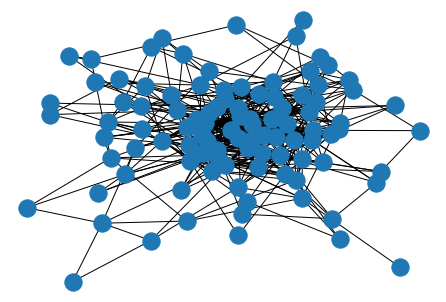

In [2]:



sizes = [50,50] # sizes of blocks
probs = [[0.2, 0.05], [0.05, 0.05]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

nx.draw(G)

# G.graph['partition'][1] get nodes from 2nd stochastic block

In [3]:

def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def crit_b(J):
    eigenvalues,_ = np.linalg.eig(J)
    return 1./np.max(np.abs(eigenvalues))

def average_degree(G,control,budget):
    return np.sum([G.degree[i]*con for i,con in enumerate(control)])/budget


In [4]:
        
class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=500,init_mag='aligned',fp_tol_fac=10-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-5):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.step_size=step_size
        if init_mag=='aligned':
            self.init_mag=np.zeros(self.graph_size)
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(system.graph_size):
            m_new[i]=system.single_mag(i,m_old,beta,field)
        return m_new

    def Steffensen_method(self,mag,beta,field,mag_delta_history=[],it=0,heuristics=False):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 107
        if len(mag_delta_history)==0 or heuristics==True:
            mag0=mag
        else:
            mag0=mag_delta_history[it]
        
        for i in range(self.fixed_point_iter):     
            mag1=self.magnetisation(mag0,beta,field)
            mag2=self.magnetisation(mag1,beta,field)
            
            if np.all((mag+mag2-2*mag1)!=0):
                mag_d = mag - (mag1-mag)**2/(mag+mag2-2*mag1) 
            else:
                mag_d = mag1
            
                    
            if np.abs(np.mean(mag1)-np.mean(mag_d))<self.fp_tol_fac: 
                break
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.')
                mag_d = mag1
                if heuristics==True:
                    mag_d = None
                
        mag_delta_history.append(mag_d)
        return mag_d,mag_delta_history
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
            gradient = (1.0 / np.linalg.norm(gradient))*gradient #Normalise

        return gradient
    
    
    def MF_IIM(self,field_budget,beta,init_control_field='uniform'):
              
        if init_control_field=='uniform':
            control_field = (field_budget/self.graph_size)*np.ones(self.graph_size)
        else:
            control_field = init_control_field

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field)

        control_field_history=[]
        control_field_history.append(control_field)
        mag_delta_history=[]
        
        mag_i,mag_delta_history = self.Steffensen_method(self.init_mag,beta,tot_field,mag_delta_history,0)
        
        for it in range(self.iim_iter):
            mag_i_grad = self.mag_grad(beta,mag_i)
            control_field = control_field_history[it]

            control_field_update = (control_field + self.step_size*mag_i_grad) # gradient ascent

            control_field_new = projection_simplex_sort(control_field_update.T,z=field_budget)

            
            tot_field = np.array(self.background_field+control_field_new)
            mag_ii,mag_delta_history = self.Steffensen_method(mag_i,beta,tot_field,mag_delta_history,it)


            if np.abs(np.mean(mag_ii)-np.mean(mag_i)) <= self.iim_tol_fac:
                final_mag=mag_ii
                break
            control_field_history.append(control_field_new)
            mag_i=mag_ii
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations.'.format(self.iim_iter))
            
        return control_field,final_mag
            
        
                
budget=20.0
h = np.zeros(len(G.nodes.keys()))

system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e2),step_size=0.01)


beta_crit=crit_b(system.adj_matrix)
beta = beta_crit
control,final_mag=system.MF_IIM(budget,beta)


In [5]:
block1,block2 = np.sum(control[:50]),np.sum(control[50:])
print(block1,block2)


11.855740932002083 8.144259067997918


In [487]:
budget=20.0


beta_min = 0.5*beta_crit 
beta_max = 3*beta_crit 

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=150,endpoint=True,base=10)
y = np.zeros(len(beta_list))
control_history=np.zeros((len(beta_list),2))

normal_params = {'graph':G,'background_field':h,
                         'iim_iter':10000,'iim_tol_fac':1e-6,'fixed_point_iter':50000,
                         'step_size':1.25,'fp_tol_fac':10-7}


for i,beta in enumerate(beta_list):
    
    
    if beta > 0.09 and beta<0.13:
        extra_params = normal_params.copy()
        extra_params['step_size']=1.5
        extra_params['fixed_point_iter'] = 500000

    else:
        system = mf_ising_system(**normal_params)
        
    control,_=system.MF_IIM(budget,beta)
    block1,block2 = np.sum(control[:50]),np.sum(control[50:])
    control_history[i]=np.array([block1,block2])
        
    if i%10==0:
        print(i,beta)

print('FINISHED')    

0 0.04285309672488253
10 0.04832892413326737
20 0.05450446026979665
30 0.061469114874355885
40 0.06932372258588475
50 0.07818200283163042
60 0.08817220626304965
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
70 0.09943897157554629
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
80 0.11214541959517817
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
90 0.12647551495063297
100 0.1426367295228842
110 0.16086304623409325
120 0.18141834666477266
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
130 0.2046002315453116
140 0.23074432943514203
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
FINISHED


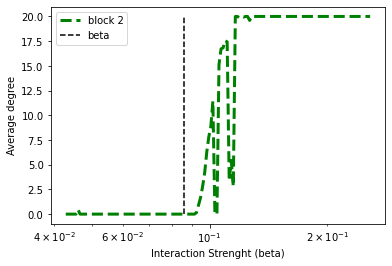

In [488]:
import matplotlib



fig,ax = plt.subplots()

#ax.plot(beta_list,control_history[:,0],c='orange',label='block 1',linestyle='dashed',linewidth=3)
ax.plot(beta_list,control_history[:,1],c='green',label='block 2',linestyle='dashed',linewidth=3)

ax.set_xscale(value='log')

plt.locator_params(axis='x',numticks=10)
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.vlines(beta_crit,ymin=0,ymax=20,linestyles='dashed',color='black',label='beta')
ax.set_xlabel(r'Interaction Strenght (beta)')

ax.legend()
plt.show()


In [6]:
print(beta_list[63])
print(beta_list[90])


NameError: name 'beta_list' is not defined

In [7]:
class monte_carlo_simulations:
    def __init__(self,graph,background_field):
        self.graph = graph
        self.graph_size = len(self.graph.nodes())
        self.adj_matrix = nx.to_numpy_matrix(graph)
        half_size = int(self.graph_size/2)
        spins = np.concatenate([np.ones(half_size),(-1)*np.ones(half_size)])
        np.random.shuffle(spins)
        self.init_spins = spins
        self.background_field = background_field
        
mc_system = monte_carlo_simulations(G,h)

In [8]:
from networkx.algorithms.centrality import closeness_centrality
import random 
import sys

def fixed_point(system,total_field,beta=beta_crit):
    mag_old = system.init_mag
    for it in range(system.fixed_point_iter):
        mag_new = system.magnetisation(mag_old,beta,total_field)
        if np.abs(np.mean(mag_new)-np.mean(mag_old))<system.fp_tol_fac: 
            break
        mag_old = mag_new
        if i+1==self.fixed_point_iter:
            print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.')
    return mag_new
    
def monte_carlo(system,control,repeat_factor=500,beta=beta_crit):
    total_mag_history = np.zeros(repeat_factor)
    mag_old = system.init_spins
    
    for jt in range(repeat_factor):
        for it in range(system.graph_size):
            spin_int = random.randint(0,len(system.init_spins)-1)
            surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)    
            hamiltonian = lambda mag: -(mag[spin_int]*(surr_spin+control[spin_int]))
            mag_rev = (-1)*mag_old[spin_int]
            mags_trial = mag_old
            mags_trial[spin_int] = mag_rev
            w = np.exp( -beta*(hamiltonian(mags_trial) - hamiltonian(mag_old)) )
            prob = random.uniform(0, 1)
            
            if prob <=w:
                mags_old = mags_trial
            else:
                continue
        total_mag = np.sum(mag_old)
        total_mag_history[jt] = total_mag
        if len(total_mag_history)>11:
            previous_average_mag=np.mean(total_mag_history[jt-10:jt-1])
        else:
            previous_average_mag = np.mean(total_mag_history[0,jt-1])
        if np.abs(total_mag-previous_average_mag)<1e-5:
            mag_final = total_mag
            break
        if (jt+1)==repeat_factor:
            print('Failed to stabilise.')
            mag_final = total_mag
    return mag_final

    
    
def monte_carlo_glauber(system,control,repeat_factor=500,beta=beta_crit):
    total_mag_history = np.zeros(repeat_factor)
    mag_old = system.init_spins
    
    for jt in range(repeat_factor):
        for it in range(system.graph_size):
            spin_int = random.randint(0,len(system.init_spins)-1)
            surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)
            
            delta_e = 2*mag_old[spin_int]*(surr_spin+control[spin_int])
            
            prob = random.uniform(0, 1)
            if prob <=(np.exp(-delta_e*beta)/(1+np.exp(-delta_e*beta))):
                mag_rev = (-1)*mag_old[spin_int]
                mag_old[spin_int] = mag_rev
        total_mag = np.sum(mag_old)
        total_mag_history[jt] = total_mag
        if len(total_mag_history)>11:
            previous_average_mag=np.mean(total_mag_history[jt-10:jt-1])
        else:
            previous_average_mag = np.mean(total_mag_history[0,jt-1])
        if np.abs(total_mag-previous_average_mag)<1e-5:
            mag_final = total_mag
            break
        if (jt+1)==repeat_factor:
            print('Failed to stabilise.')
            mag_final = total_mag
    return mag_final

def degree(system,budget,beta=beta_crit):
    sum_degree = np.sum([system.graph.degree[node] for node in system.graph.nodes])
    control_field = np.array([(system.graph.degree[node]/sum_degree)*budget for node in system.graph.nodes])
    

    assert np.round(np.sum(control_field),3)==budget

    tot_field = np.array(system.background_field+control_field)
    
    #mag=monte_carlo_glauber(system,tot_field,beta=beta_crit)
    mag=fixed_point(system,tot_field,beta)


    return np.sum(mag)

def centrality(system,budget,beta=beta_crit):
    centrality = closeness_centrality(system.graph)
    sum_centrality=sum(centrality.values())
    control_field = np.array([(centrality[node]/sum_centrality)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    mag=fixed_point(system,tot_field)
    #mag=monte_carlo_glauber(system,tot_field)


    return np.sum(mag)


def random_set(system,budget,beta=beta_crit):
    random_arr = [int(100*random.random()) for i in range(system.graph_size)]
    random_dic = {i:k for i,k in zip(system.graph.nodes,random_arr)}
    sum_random = np.sum(random_arr)
    control_field = np.array([(random_dic[node]/sum_random)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    mag=fixed_point(system,tot_field)
    #mag=monte_carlo_glauber(system,tot_field)

    
    return np.sum(mag) if np.all(mag!=None) else mag

def randomly(system,budget,beta=beta_crit):
    iters = 20
    mags=np.zeros(iters)
    for i in range(iters):
        mag=random_set(system,budget,beta)
        if np.all(mag!=None):
            mags[i]=mag
    return np.mean(mags)



In [9]:
budget = 40
mag = centrality(system,budget)
print(mag)




3.4268430274530863


In [10]:
budgets = np.arange(1,200,5)
system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=10000,step_size=1.25)

all_types={'MF':[],'Central':[],'Random':[],'Degree':[]}

for budget in budgets:
    print(budget)
    #print('MF')
    control,final_mag=system.MF_IIM(budget,beta_crit)
    mag_mf = np.sum(final_mag)
    all_types['MF'].append(mag_mf)
    
    #print('Central')
    mag_c= centrality(system,budget)
    all_types['Central'].append(mag_c)

    #print('Degree')
    mag_d = degree(system,budget)
    all_types['Degree'].append(mag_d)

    #print('Random')
    mag_r= randomly(system,budget)
    all_types['Random'].append(mag_r)




1
6
11
16
21
26
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
31
36
41
46
51
56
61
66
71
76
81
86
91
96
101
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
106
111
116
121
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
126
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
131
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
136
141
146
151
156
161
166
171
176
181
186
191
196


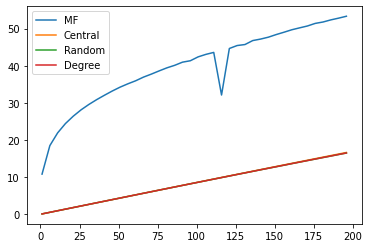

In [11]:
fig,ax=plt.subplots()

ax.plot(budgets,all_types['MF'],label='MF')
ax.plot(budgets,all_types['Central'],label='Central')
ax.plot(budgets,all_types['Random'],label='Random')
ax.plot(budgets,all_types['Degree'],label='Degree')
ax.legend()
plt.show()

In [196]:
x=np.concatenate([np.ones(50),(-1)*np.ones(50)])
np.random.shuffle(x)
print(x)

[-1.  1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1.
  1. -1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.
  1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.
 -1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
 -1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1.
 -1. -1. -1.  1.  1.  1. -1.  1. -1. -1.]


In [105]:
np.random.shuffle( np.ones( int(self.graph_size/2) )+(-1)*np.ones( int(self.graph_size/2) ) ) 


52.54822922215996